# RMSprop- 64 - Entropy

Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist, cifar10

import matplotlib.pyplot as plt
import tempfile
# limit GPU memory to stop kernel crashw
#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpu_devices[0], True)
#
layers = tf.keras.layers
import numpy as np
print(tf.__version__)
#print (gpu_devices)

from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
import tensorflow_model_optimization as tfmot

2.3.1


In [ ]:
# Loading Fashion MNIST datset

(train_X, train_Y), (val_X, val_Y) = fashion_mnist.load_data()

In [ ]:
# converting all the pixel values from range(0 to 255) to range(0,1)
train_X = train_X/255.
val_X = val_X/255.

#converting the Image data into values of pixels, i.e. - image of dimension 28 X 28 to single row of 784 pixels(28x28 = 784).
print("Dimension of training data before reshaping",train_X.shape)
train_X = train_X.reshape(-1, 784)
val_X = val_X.reshape(-1, 784)
print("Dimension of training data after reshaping",train_X.shape)
print("Dimension of validation data after reshaping",val_X.shape)

Dimension of training data before reshaping (60000, 28, 28)
Dimension of training data after reshaping (60000, 784)
Dimension of validation data after reshaping (10000, 784)


### 4) CNN on CIFAR10 dataset

In [ ]:
# CNN

def prepare_cifar10_data(subtract_pixel_mean = True):

    #load cifar10 data and returns the data in the format required

    # The data, split between train and test sets:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    num_classes=10
    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    # Convert class vectors to binary class matrices.
    y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
    y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train),(x_test,y_test)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def CNN(input_shape, num_classes=10):

    #CNN model for CIFAR10

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
    #Categorical crossentropy loss function used

    init = model.get_weights()

    return model, init


def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    # Not used here. Used if we wanted to compare compression of models
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)



##Functions for pruning CNN - same as the pruning functions of autoencoders, but for CNN####

def cnn_pruning(model, train_X, train_Y, test_X, test_Y, batch_size, epochs, final_sparsity):

    # Function pruning 5% of weights of model over epochs epochs and returning the error on test data
    # and size of compressed file (not used here)

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = train_X.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
    print(f'cnn_pruning with final_sparsity: {final_sparsity}')

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=final_sparsity,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
    # `prune_low_magnitude` requires a recompile.
    model_pruning.compile(optimizer=RMSprop(lr=0.001, epsilon=1e-7), loss='categorical_crossentropy')
    # Model callbacks
    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep()
    ]
    # Fitting data
    model_pruning.fit(train_X, train_Y,
                          batch_size=batch_size,
                          validation_data=(test_X,test_Y),
                          epochs=epochs,
                          callbacks=callbacks)
    # Export the model
    model_for_export = tfmot.sparsity.keras.strip_pruning(model_pruning)
    _, pruned_keras_file = tempfile.mkstemp('.h5')
    #save_model(model_for_export, pruned_keras_file, include_optimizer=False)
    model_for_export.save(pruned_keras_file, include_optimizer=False)
    print(f'Pruned model saved: {pruned_keras_file}')

    # to predict the reconstructed images for the original images...
    pred_pruning = model_pruning.predict(test_X)
    cce = tf.keras.losses.CategoricalCrossentropy()
    error_prun=cce(test_Y, pred_pruning).numpy()
    size_pruned_file=get_gzipped_model_size(pruned_keras_file)

    return error_prun, size_pruned_file


def cnn_prune_all(model, train_X, train_Y, test_X, test_Y, batch_size, epochs):

    #####NOTE#####
    # There is a bug in tfmot.sparsity.keras.PolynomialDecay#
    # When I try to pass final_sparsity=final_sparsity it triggers an error
    # When we input a number manually it works
    # Otherwise clearly I would have done a loop
    #########

    # Pruning between 5% and 95% of weights in order to make plot

    err_prun_list=[]
    size_prun_file_list=[]

    for i in range(5, 96, 5):
        error_prun, size_pruned_file = cnn_pruning(model=model, train_X=train_X, train_Y=train_Y, test_X=test_X,
                                                   test_Y=test_Y, batch_size=batch_size,epochs=epochs, final_sparsity=i / 100.0)
        err_prun_list.append(error_prun)
        size_prun_file_list.append(size_pruned_file)

    return err_prun_list, size_prun_file_list




In [ ]:
num_classes=10
#Loading CIFAR10 data (10 classes)
(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)

# Making CNN model
cnn_cifar, init = CNN(input_shape=x_train.shape[1:])
# Training CNN model 50 epochs
cnn_cifar.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopper])

#calculating Categorical crossentropy loss on test data
pred6 = cnn_cifar.predict(x_test)
cce = tf.keras.losses.CategoricalCrossentropy()

error6=cce(y_test, pred6).numpy()
print(error6)
error6_list=np.ones(19)*error6

#Pruning CNN and getting errors per percentage of synapses pruned

err_prun6_list, size_prun6_file_list =cnn_prune_all(model=cnn_cifar, train_X=x_train, train_Y=y_train,
                                                    test_X=x_test, test_Y=y_test, batch_size=128, epochs=5)

Learning rate:  0.001
Epoch 1/50
391/391 [==============================] - 323s 827ms/step - loss: 1.5470 - accuracy: 0.4406 - val_loss: 1.2059 - val_accuracy: 0.5731
Epoch 2/50
391/391 [==============================] - 364s 931ms/step - loss: 1.0716 - accuracy: 0.6233 - val_loss: 1.0459 - val_accuracy: 0.6249
Epoch 3/50
391/391 [==============================] - 338s 864ms/step - loss: 0.8341 - accuracy: 0.7112 - val_loss: 0.8990 - val_accuracy: 0.6971
Epoch 4/50
391/391 [==============================] - 316s 808ms/step - loss: 0.6699 - accuracy: 0.7667 - val_loss: 0.7807 - val_accuracy: 0.7342
Epoch 5/50
391/391 [==============================] - 319s 815ms/step - loss: 0.5319 - accuracy: 0.8172 - val_loss: 0.7765 - val_accuracy: 0.7397
Epoch 6/50
391/391 [==============================] - 303s 776ms/step - loss: 0.4106 - accuracy: 0.8585 - val_loss: 0.7708 - val_accuracy: 0.7614
Epoch 7/50
391/391 [==============================] - 289s 738ms/step - loss: 0.3011 - accuracy: 0.896

391/391 [==============================] - 265s 678ms/step - loss: 0.0153 - val_loss: 5.1914
Epoch 5/5
391/391 [==============================] - 230s 589ms/step - loss: 0.0116 - val_loss: 5.3892
Pruned model saved: /var/folders/wb/jbgkphrs6hjbdj8nwrl89gg80000gn/T/tmplqot32kt.h5
cnn_pruning with final_sparsity: 0.5
Epoch 1/5
391/391 [==============================] - 232s 594ms/step - loss: 0.0413 - val_loss: 5.3772
Epoch 2/5
391/391 [==============================] - 248s 635ms/step - loss: 0.0225 - val_loss: 5.6163
Epoch 3/5
391/391 [==============================] - 236s 603ms/step - loss: 0.0102 - val_loss: 5.5293
Epoch 4/5
391/391 [==============================] - 229s 586ms/step - loss: 0.0139 - val_loss: 5.8568
Epoch 5/5
391/391 [==============================] - 213s 545ms/step - loss: 0.0122 - val_loss: 5.0796
Pruned model saved: /var/folders/wb/jbgkphrs6hjbdj8nwrl89gg80000gn/T/tmplgxhykm6.h5
cnn_pruning with final_sparsity: 0.55
Epoch 1/5
391/391 [===========================

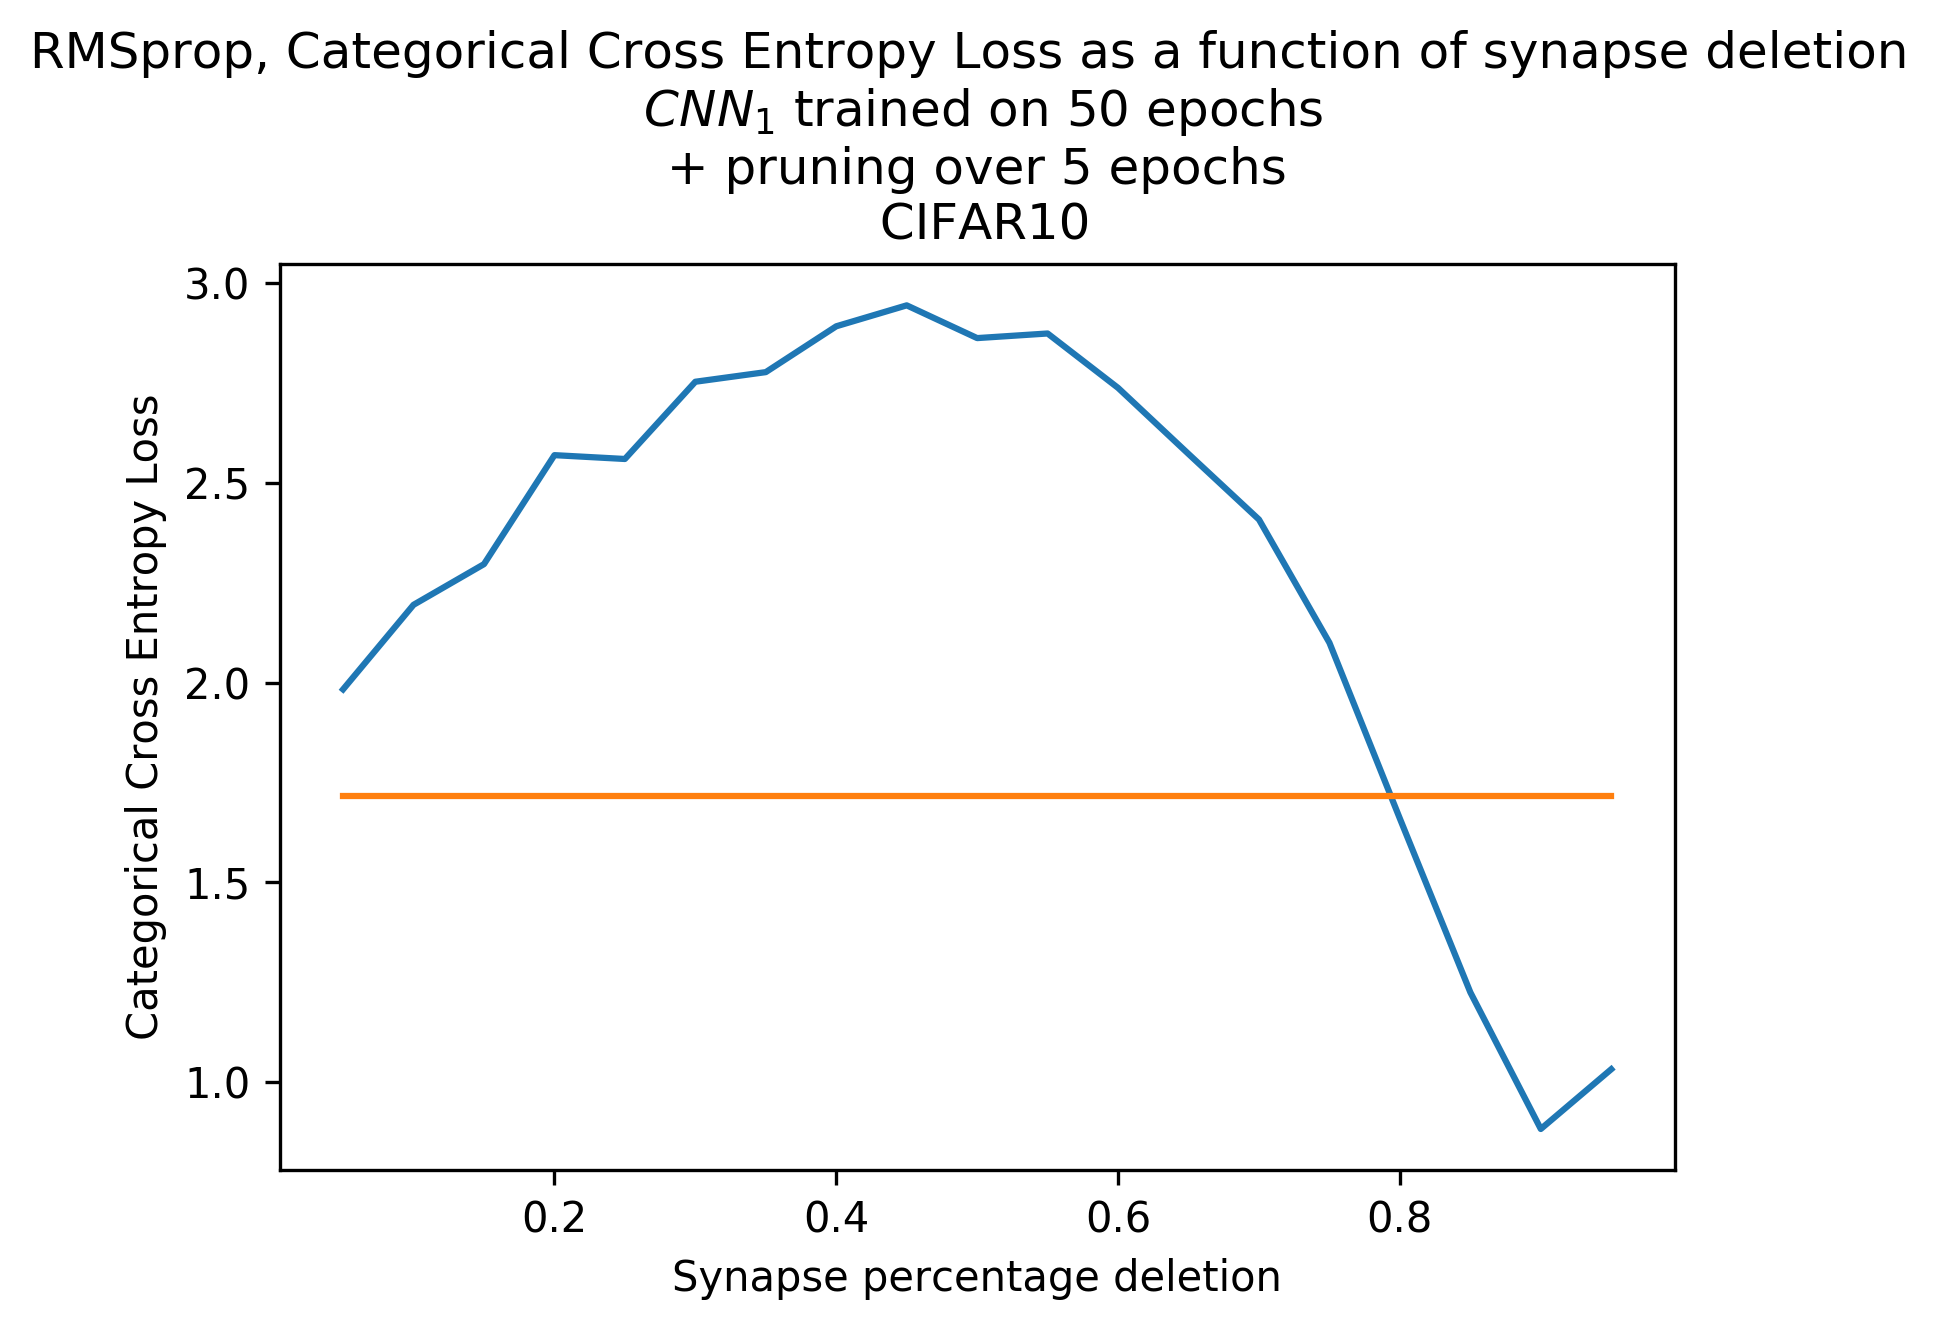

In [ ]:
synapse_deletion=np.arange(0.05,1.,0.05)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.plot(synapse_deletion,err_prun6_list)
plt.plot(synapse_deletion,error6_list)
plt.title("RMSprop, Categorical Cross Entropy Loss as a function of synapse deletion \n $CNN_1$ trained on 50 epochs \n + pruning over 5 epochs \n CIFAR10")
plt.xlabel("Synapse percentage deletion")
plt.ylabel("Categorical Cross Entropy Loss")
plt.show()

### Observations: Contrary to Autoencoder, pruning up to 80% of weights does not help performance, but pruning between 80% and 95% of weights helps performance on test data